# 房价预测案例（进阶版）

这是进阶版的notebook。主要是为了比较几种模型框架。所以前面的特征工程部分内容，我也并没有做任何改动，重点都在后面的模型建造section

## Step 1: 检视源数据集

In [1]:
import numpy as np
import pandas as pd

#### 读入数据

* 一般来说源数据的index那一栏没什么用，我们可以用来作为我们pandas dataframe的index。这样之后要是检索起来也省事儿。

* 有人的地方就有鄙视链。跟知乎一样。Kaggle的也是个处处呵呵的危险地带。Kaggle上默认把数据放在*input*文件夹下。所以我们没事儿写个教程什么的，也可以依据这个convention来，显得自己很有逼格。。

In [2]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)

#### 检视源数据

In [3]:
train_df.head(10)

#test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


这时候大概心里可以有数，哪些地方需要人为的处理一下，以做到源数据更加好被process。

## Step 2: 合并数据

这么做主要是为了用DF进行数据预处理的时候更加方便。等所有的需要的预处理进行完之后，我们再把他们分隔开。

首先，SalePrice作为我们的训练目标，只会出现在训练集中，不会在测试集中（要不然你测试什么？）。所以，我们先把*SalePrice*这一列给拿出来，不让它碍事儿。

我们先看一下*SalePrice*长什么样纸：

,log(price + 1),price
Id,,
1,12.247699,208500
2,12.109016,181500
3,12.317171,223500
4,11.849405,140000
5,12.429220,250000


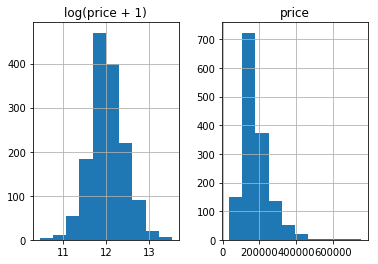

In [4]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()
prices.head()

可见，label本身并不平滑。为了我们分类器的学习更加准确，我们会首先把label给“平滑化”（正态化）

这一步大部分同学会miss掉，导致自己的结果总是达不到一定标准。

这里我们使用最有逼格的log1p, 也就是 log(x+1)，避免了复值的问题。

记住哟，如果我们这里把数据都给平滑化了，那么最后算结果的时候，要记得把预测到的平滑数据给变回去。

按照“怎么来的怎么去”原则，log1p()就需要expm1(); 同理，log()就需要exp(), ... etc.

In [5]:
y_train = np.log1p(train_df.pop('SalePrice'))
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

然后我们把剩下的部分合并起来

In [6]:
all_df = pd.concat((train_df, test_df), axis=0)
all_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


此刻，我们可以看到all_df就是我们合在一起的DF

In [7]:
all_df.shape

(2919, 79)

而*y_train*则是*SalePrice*那一列

In [8]:
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

## Step 3: 变量转化

类似『特征工程』。就是把不方便处理或者不unify的数据给统一了。

#### 正确化变量属性

首先，我们注意到，*MSSubClass* 的值其实应该是一个category，

但是Pandas是不会懂这些事儿的。使用DF的时候，这类数字符号会被默认记成数字。

这种东西就很有误导性，我们需要把它变回成*string*

In [9]:
all_df['MSSubClass'].dtypes
type(all_df['MSSubClass'])

pandas.core.series.Series

In [10]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)


变成*str*以后，做个统计，就很清楚了

In [11]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

#### 把category的变量转变成numerical表达形式

当我们用numerical来表达categorical的时候，要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。于是我们可以用One-Hot的方法来表达category。

pandas自带的get_dummies方法，可以帮你一键做到One-Hot。

In [12]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


此刻*MSSubClass*被我们分成了12个column，每一个代表一个category。是就是1，不是就是0。

同理，我们把所有的category数据，都给One-Hot了

In [13]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


#### 处理好numerical变量

就算是numerical的变量，也还会有一些小问题。

比如，有一些数据是缺失的：

In [14]:
all_dummy_df.isnull().sum().sort_values(ascending=False)


LotFrontage             486
GarageYrBlt             159
MasVnrArea               23
BsmtHalfBath              2
BsmtFullBath              2
BsmtFinSF2                1
GarageCars                1
TotalBsmtSF               1
BsmtUnfSF                 1
GarageArea                1
BsmtFinSF1                1
Condition1_Artery         0
Condition2_Feedr          0
Condition2_Artery         0
Neighborhood_Somerst      0
Neighborhood_StoneBr      0
Neighborhood_Timber       0
Neighborhood_Veenker      0
Condition1_Feedr          0
Condition1_RRAn           0
Condition1_RRNn           0
Condition1_RRNe           0
Condition1_Norm           0
Condition1_PosA           0
Neighborhood_SawyerW      0
Condition1_RRAe           0
Condition1_PosN           0
Neighborhood_OldTown      0
Neighborhood_Sawyer       0
Neighborhood_MeadowV      0
                       ... 
BsmtFinType2_ALQ          0
BsmtFinType2_BLQ          0
BsmtFinType2_GLQ          0
BsmtFinType2_LwQ          0
BsmtFinType2_Rec    

可以看到，缺失最多的column是LotFrontage

处理这些缺失的信息，得靠好好审题。一般来说，数据集的描述里会写的很清楚，这些缺失都代表着什么。当然，如果实在没有的话，也只能靠自己的『想当然』。。

在这里，我们用平均值来填满这些空缺。

In [15]:
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [18]:
all_dummy_df = all_dummy_df.fillna(mean_cols)

看看是不是没有空缺了？

In [19]:
all_dummy_df.isnull().sum().sum()

0

#### 标准化numerical数据

这一步并不是必要，但是得看你想要用的分类器是什么。一般来说，regression的分类器都比较傲娇，最好是把源数据给放在一个标准分布内。不要让数据间的差距太大。

这里，我们当然不需要把One-Hot的那些0/1数据给标准化。我们的目标应该是那些本来就是numerical的数据：

先来看看 哪些是numerical的：

In [20]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

计算标准分布：(X-X')/s

让我们的数据点更平滑，更便于计算。

注意：我们这里也是可以继续使用Log的，我只是给大家展示一下多种“使数据平滑”的办法。

In [21]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## Step 4: 建立模型

#### 把数据集分回 训练/测试集

In [22]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
dummy_train_df

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-2.020329e-01,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.525112,0.580807,-0.293080,-0.934702,...,0,0,0,1,0,0,0,0,1,0
2,5.017845e-01,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.572152,1.177910,-0.293080,-0.629788,...,0,0,0,1,0,0,0,0,1,0
3,-6.126943e-02,0.137173,0.646073,-0.507197,0.980053,0.848819,0.334770,0.097856,-0.293080,-0.288467,...,0,0,0,1,0,0,0,0,1,0
4,-4.366387e-01,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.572152,-0.494856,-0.293080,-0.047266,...,0,0,0,1,1,0,0,0,0,0
5,6.894691e-01,0.518814,1.355319,-0.507197,0.947040,0.753100,1.387248,0.468851,-0.293080,-0.161040,...,0,0,0,1,0,0,0,0,1,0
6,7.363903e-01,0.500430,-0.772420,-0.507197,0.715952,0.513801,-0.572152,0.637883,-0.293080,-1.130393,...,0,0,0,1,0,0,0,0,1,0
7,2.671787e-01,-0.010665,1.355319,-0.507197,1.079091,0.992399,0.469129,2.036246,-0.293080,-0.554698,...,0,0,0,1,0,0,0,0,1,0
8,-1.800332e-14,0.027119,0.646073,0.391170,0.055700,-0.539116,0.771437,0.916678,-0.103928,-0.784521,...,0,0,0,1,0,0,0,0,1,0
9,-8.589292e-01,-0.513264,0.646073,-0.507197,-1.330831,-1.639892,-0.572152,-0.969026,-0.293080,0.890230,...,0,0,0,1,1,0,0,0,0,0


In [23]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

In [24]:
X_train = dummy_train_df.values

X_test = dummy_test_df.values
type(X_train)

numpy.ndarray

#### 做一点高级的Ensemble

一般来说，单个分类器的效果真的是很有限。我们会倾向于把N多的分类器合在一起，做一个“综合分类器”以达到最好的效果。

我们从刚刚的试验中得知，Ridge(alpha=15)给了我们最好的结果

In [26]:
from sklearn.linear_model import Ridge
ridge = Ridge(15)

#### Bagging

Bagging把很多的小分类器放在一起，每个train随机的一部分数据，然后把它们的最终结果综合起来（多数投票制）。

Sklearn已经直接提供了这套构架，我们直接调用就行：

In [27]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

在这里，我们用CV结果来测试不同的分类器个数对最后结果的影响。

注意，我们在部署Bagging的时候，要把它的函数base_estimator里填上你的小分类器（ridge）

In [31]:
params = [1, 10, 15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(test_score)

In [32]:
test_scores

[array([0.12640287, 0.10520956, 0.12886703, 0.17632199, 0.14381127,
        0.11963764, 0.11865334, 0.10050443, 0.24733601, 0.12157693]),
 array([0.12062287, 0.09980294, 0.11309613, 0.17777241, 0.13964825,
        0.10978033, 0.12329401, 0.10140911, 0.23782652, 0.13135928]),
 array([0.12276975, 0.09918054, 0.10904253, 0.17592207, 0.1409529 ,
        0.1066151 , 0.12172366, 0.10012557, 0.23140289, 0.12750136]),
 array([0.1228471 , 0.10326812, 0.10786877, 0.17535056, 0.1419135 ,
        0.10338402, 0.12471824, 0.10042982, 0.2302843 , 0.12964041]),
 array([0.1210335 , 0.09708103, 0.10812854, 0.17581219, 0.14090053,
        0.10739414, 0.12053342, 0.10105788, 0.23255504, 0.12966741]),
 array([0.12219483, 0.10251949, 0.10785774, 0.17904637, 0.14064811,
        0.10621649, 0.12361714, 0.10273578, 0.2224657 , 0.12896268]),
 array([0.12095487, 0.10055683, 0.10712193, 0.17812641, 0.14051264,
        0.10426246, 0.12449222, 0.10399384, 0.23211129, 0.13238819])]

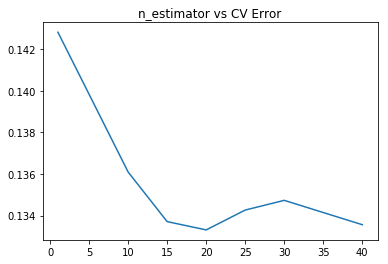

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

可见，前一个版本中，ridge最优结果也就是0.135；而这里，我们使用20个小ridge分类器的bagging，达到了低于0.132的结果。

当然了，你如果并没有提前测试过ridge模型，你也可以用Bagging自带的DecisionTree模型：

代码是一样的，把base_estimator给删去即可

In [30]:
params = [10, 15, 20, 25, 30, 40, 50, 60, 70, 100]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

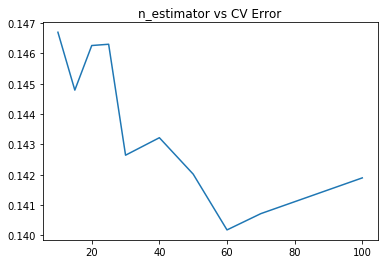

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

咦，看来单纯用DT不太灵光的。最好的结果也就0.140

#### Boosting

Boosting比Bagging理论上更高级点，它也是揽来一把的分类器。但是把他们线性排列。下一个分类器把上一个分类器分类得不好的地方加上更高的权重，这样下一个分类器就能在这个部分学得更加“深刻”。

In [36]:
from sklearn.ensemble import AdaBoostRegressor

In [37]:
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

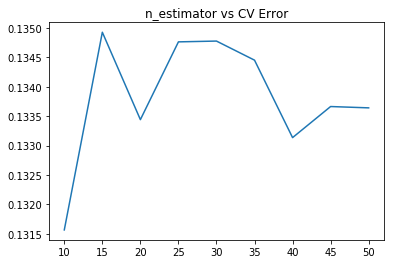

In [38]:
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

Adaboost+Ridge在这里，20个小分类器的情况下，也是达到了接近0.132的效果。

同理，这里，你也可以不必输入Base_estimator，使用Adaboost自带的DT。

In [39]:
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

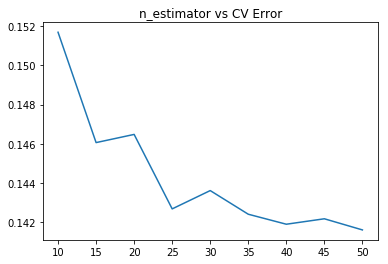

In [40]:
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

看来我们也许要先tune一下我们的DT模型，再做这个实验。。:P

#### XGBoost

最后，我们来看看巨牛逼的XGBoost，外号：Kaggle神器

这依旧是一款Boosting框架的模型，但是却做了很多的改进。

In [41]:
from xgboost import XGBRegressor

用Sklearn自带的cross validation方法来测试模型

In [42]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

存下所有的CV值，看看哪个alpha值更好（也就是『调参数』）

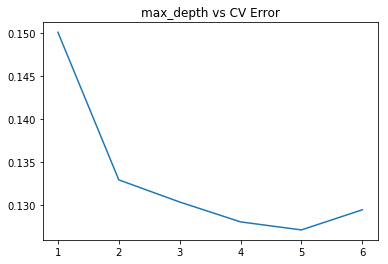

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");

惊了，深度为5的时候，错误率缩小到0.127

这就是为什么，浮躁的竞赛圈，人人都在用XGBoost :)